In [1]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numba import jit
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import root_scalar
from pynndescent import NNDescent
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA

In [2]:
def exp_k(dists, sigma):
    return np.exp(- (dists - dists[0]) / sigma).sum()

In [3]:
def find_sigma(d, k, lower_bound=1e-6, upper_bound=1e6):
    return root_scalar(
        lambda s: exp_k(d, s) - np.log2(k),
        bracket=(lower_bound, upper_bound)
    ).root

In [4]:
def w_ij_sym(x, k, verbose=False):
    num_pts = x.shape[0]
    if verbose:
        print('Indexing')
    index = NNDescent(x)
    neighbors = np.empty((num_pts, k), dtype=np.int)
    w_ij = np.empty((num_pts, k))
    for i, xi in enumerate(x):
        if verbose:
            print('Calculating graph weights: {cur}/{tot}'.format(
                cur=i+1, tot=num_pts), end='\r')
        nn, dists = index.query([xi], k+1)
        sigma = find_sigma(dists[0, 1:], k)
        neighbors[i] = nn[0, 1:]
        w_ij[i] = np.exp(- (dists[0, 1:] - dists[0, 1]) / sigma)
    row_indices = np.repeat(np.arange(num_pts), k)
    w = csr_matrix((w_ij.ravel(), (row_indices, neighbors.ravel())))
    return w + w.transpose() - (w.multiply(w.transpose()))

In [5]:
def pdiff(x):
    batch_size = x.shape[0] 
    expanded = x.unsqueeze(1)
    tiled = torch.repeat_interleave(expanded, batch_size, dim=1)
    diffs = tiled - tiled.transpose(0, 1)  
    return diffs

In [69]:
def attractive(diffs, w, a, b):
    sq_norms = diffs.pow(2).sum(axis=1)
    return (-2*a*b*sq_norms.pow(b-1) / (1 + sq_norms) * (w * diffs.t())).t()

In [73]:
def repulsive(diffs, w, b, eps=0.001):
    sq_norms = diffs.pow(2).sum(axis=1)
    return (b / (eps + sq_norms) / (1 + sq_norms) * (1 - w) * diffs.t()).t()

In [96]:
def total(diffs, w, a, b, eps=0.001):
    attr = attractive(diffs, w, a, b)
    repl = repulsive(diffs, w, a, b)
    tot = attr + repl
    return tot.pow(2).sum()

--------------

In [8]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [9]:
mnist = MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

In [10]:
testdata = mnist.data.reshape(-1, 28*28) / 255.

In [11]:
from matplotlib import pyplot as plt

In [16]:
foo = w_ij_sym(testdata[:200].numpy(), 20, verbose=True)

Indexing


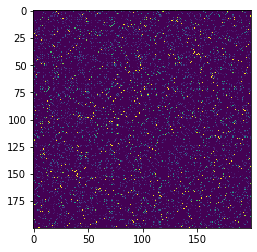

In [19]:
plt.imshow(foo.toarray())